In [1]:
#Instalar estas librerías en caso de no tenerlas

#pip install pandas
#pip install numpy
#pip install scikit-learn
#pip install imbalanced-learn
#pip install matplotlib
#pip install seaborn
#pip install plotly

In [2]:
#Abrimos la base de datos de Clientes
#Importamos la librería pandas y matplotlib 
import pandas as pd
import numpy as np
%matplotlib widget
pd.options.display.max_columns = None
#Llamamos la tabla cliente.csv
df= pd.read_csv("reto.csv")
#Mostramos la información de la tabla (columnas, valores no nulos y tipo de dato)
df.info()
import warnings
warnings.filterwarnings('ignore')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [3]:
#Llamamos las librerías que usaremos

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics as mt
from IPython.display import Image as PImage
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [4]:
#Visualizamos la data
df.head(-30)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362585,741,CASH_OUT,0.00,C312737633,0.00,0.00,C1400061387,267522.87,267522.87,1,0
6362586,741,TRANSFER,62297.18,C1565612524,62297.18,0.00,C435734396,0.00,0.00,1,0
6362587,741,CASH_OUT,62297.18,C1597957921,62297.18,0.00,C734451013,1060553.11,1122850.29,1,0
6362588,741,TRANSFER,114149.44,C1157446475,114149.44,0.00,C1367473638,0.00,0.00,1,0


In [5]:
#Verificamos si hay valores nulos
df.isnull().values.any()

False

In [6]:
#Verificamos si hay valores duplicados
df.duplicated().any()

False

In [7]:
#Verificamos cuántas transaccinoes hay según el tipo de transacción
print(df['type'].value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


In [8]:
#Visualizamos cuántas transacciones son fraudulentas y cuántas no
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Análisis de Datos Sesgados
Antes de generar el modelo es importante entender todas las variables. Se observará la existencia de diferentes proporciones en algunas variables, si esto sucede, podríamos tener un problema GIGO (Garbage In, Garbage Out).

Esto es muy importante porque los modelos de Machine Learning ayudan a las personas a tomar decisiones importantes y si el modelo se encuentra sesgado, esto hará que se propague en diferentes áreas de la sociedad!

In [9]:
df['isFraud'].value_counts(normalize=True) * 100

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

Se observa que en la variable isFraud aparece que un gran porcentaje de los datos obtenidos pertenecen a 0, es decir, no es fraude, por lo que existe un gran sesgo y se podría producir un problema de GIGO (Garbage In, Gargabe Out), es decir que la predicción puede decir que todas las transacciones no son fraudulentas.

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


Text(0.5, 1.0, 'Tipo de transacción cuando hay fraude')

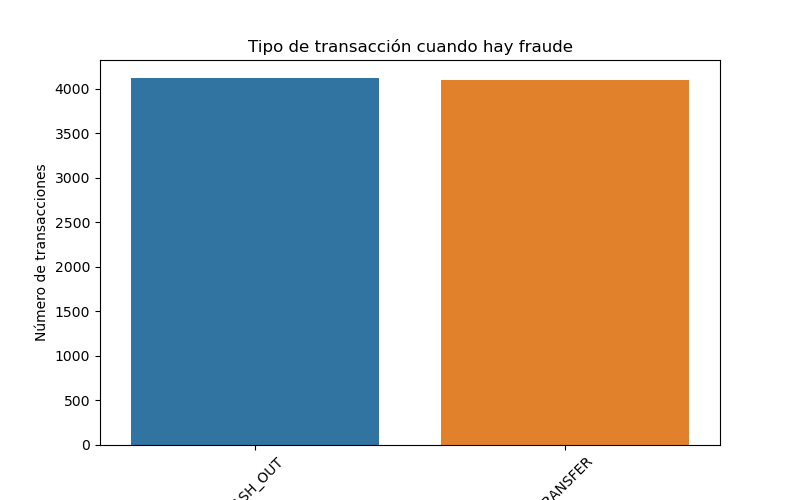

In [10]:
#Vemos en que tipo de transacciones se han detectado fraude 
print(df[(df['isFraud'] == 1)]['type'].value_counts())

plt.figure(figsize=(8,5))
sns.countplot(x='type', data=df[(df['isFraud'] == 1)], order=df[(df['isFraud'] == 1)]['type'].value_counts().index)
plt.xticks(rotation= 45) # Rotación del texto en el eje x
plt.xlabel('Tipo de transacción')
plt.ylabel('Número de transacciones')
plt.title('Tipo de transacción cuando hay fraude')

Se observa que todas las transacciones fraudulentas han sido realizadas entre Cash_out y Transfer

<Axes: xlabel='isFraud', ylabel='amount'>

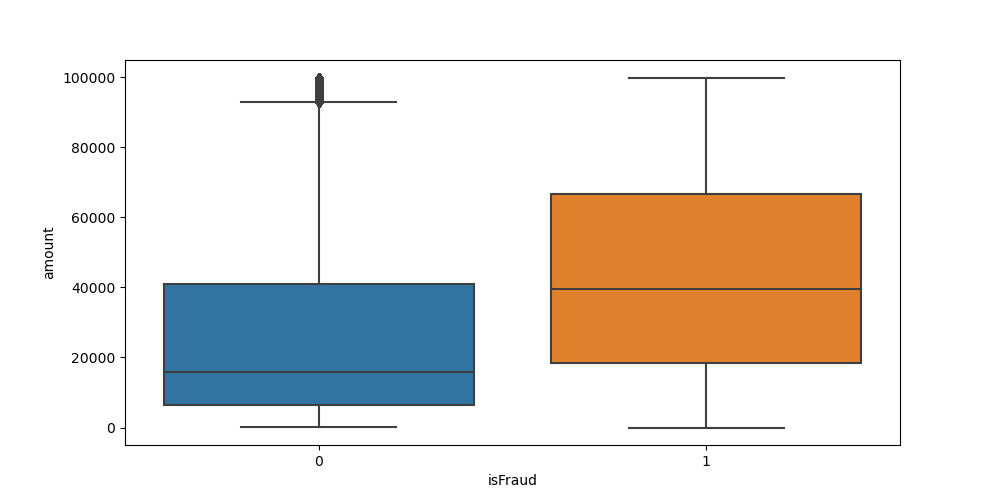

In [11]:
#Se analiza la distribución de la variable isFraud con la variable amount
plt.figure(figsize=(10,5))
sns.boxplot(x = 'isFraud', y = 'amount', data = df[df.amount < 1e5])

Se observa que ocurren más fraudes cuando la variable amount es mayor.

# Preparación de base para modelo

In [12]:
#Se eliminan las variables categóricas y se agregan variables dummy de la variable type para analizar por tipo de transacción
df2 = pd.concat([df.drop(columns=['isFraud','isFlaggedFraud']),pd.get_dummies(df.type)] ,axis=1)
df2 = df2.drop(['type', 'nameOrig', 'nameDest'],1)
df2 = pd.concat([df2,df.iloc[:,-2:]],axis=1)
pd.DataFrame.head(df2)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   CASH_IN         uint8  
 7   CASH_OUT        uint8  
 8   DEBIT           uint8  
 9   PAYMENT         uint8  
 10  TRANSFER        uint8  
 11  isFraud         int64  
 12  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), uint8(5)
memory usage: 418.7 MB


Contamos cuantas datos hay de las dos variables que presentan transacciones fraudulentas

In [13]:
df2['CASH_OUT'].value_counts()

0    4125120
1    2237500
Name: CASH_OUT, dtype: int64

In [14]:
df2['TRANSFER'].value_counts()

0    5829711
1     532909
Name: TRANSFER, dtype: int64

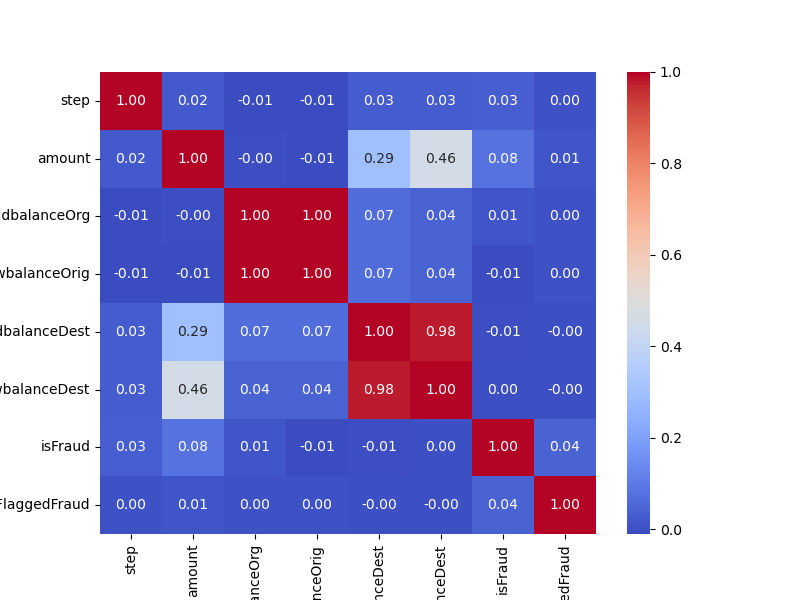

In [15]:
#Realizamos una matriz de correlación para evaluar si se elimina alguna variable que sea redundante
correlation_matrix=df.corr()

plt.figure(figsize=(8, 6))

# Crear un mapa de calor con Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Mostrar la figura
plt.show()

Se encuentra que las variables Oldbalanceorg y Newbalanceorig tienen una correlación perfecta al igual que las variables oldbalancedest y newbalancedest. Por falta de información de qué hacen estas variables se decide continuar con estas variables sin eliminarlas.

In [16]:
# creación de la tabla de contingencia con las dos columnas que se quieren estudiar
observados = pd.crosstab(df['isFraud'], df.type, margins=True)
observados

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,All
isFraud,,,,,,
0,1399284,2233384,41432,2151495,528812,6354407
1,0,4116,0,0,4097,8213
All,1399284,2237500,41432,2151495,532909,6362620


In [17]:
#Columnas que se utilizarán para entrenar el modelo
cols = ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest", 'CASH_OUT','TRANSFER']

# Aplicando Decision Tree Classifier

In [18]:
X=df2[cols]
y =df2[['isFraud']]

In [19]:
X_orig = X.copy()
y_orig = y.copy()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [21]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [22]:
model_dt.score(X_test, y_test)

0.9997338622559051

In [23]:
print("score en data de entrenamiento: {:.4f}".format(model_dt.score(X_train, y_train)))
print("score en data de validacion: {:.4f}".format(model_dt.score(X_test, y_test)))

score en data de entrenamiento: 1.0000
score en data de validacion: 0.9997


Tenemos overfitting. Nuestro modelo tiene una performance excelente en nuestro dataset de entrenamiento, sin embargo, no generaliza bien para los datos de testing.

In [24]:
# Making predictions
y_pred_dt = model_dt.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.90      0.89      0.89      2435

    accuracy                           1.00   1908786
   macro avg       0.95      0.94      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786



In [25]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred_dt))
print('Accuracy of Decision Tree :',accuracy_score(y_test,y_pred_dt))
print('Sensitivity of Decision Tree :',recall_score(y_test,y_pred_dt))

[[1906114     237]
 [    271    2164]]
Accuracy of Decision Tree : 0.9997338622559051
Sensitivity of Decision Tree : 0.8887063655030801


In [26]:
optimal_tree = DecisionTreeClassifier(max_depth=4)
optimal_tree.fit(X_train, y_train)
print("--"*12)
print(f'train score: {optimal_tree.score(X_train, y_train):.4f}')
print(f'test score: {optimal_tree.score(X_test, y_test):.4f}')

------------------------
train score: 0.9991
test score: 0.9991


In [27]:
#kfold_validation=KFold(10)

#results=cross_val_score(model_dt,X,y,cv=kfold_validation)
#print(results)
#print(np.mean(results))

# Aplicando Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = X_orig.copy()
y = y_orig.copy()

X_train,X_test,y_train,y_test =train_test_split(X_orig, y_orig, stratify=y_orig, random_state=100)

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print(classification_report(y_test,prediction_test))

In [ ]:
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

In [ ]:
print ('Random Forest Accuracy with Default Hyperparameter', metrics.accuracy_score(y_test, prediction_test))
print ('Random Forest Recall with Default Hyperparameter  ', recall_score(y_test, prediction_test))

In [ ]:
y_prob = model_rf.predict_proba(X_test)[:, 1]  # Selecciona las probabilidades de la clase positiva

# Calcula el AUC-ROC Score
auc_roc = roc_auc_score(y_test, prediction_test)

print("AUC-ROC Score:", auc_roc)

In [ ]:
# Suponiendo que ya has entrenado tu modelo de Random Forest y lo has asignado a model_rf
feature_importance = model_rf.feature_importances_

# Ahora puedes imprimir o procesar la importancia de las características
print(feature_importance)

# Graficando el árbol

In [ ]:
# Suponiendo que ya has entrenado tu modelo de Random Forest y lo has asignado a model_rf
feature_importance = model_dt.feature_importances_

# Ahora puedes imprimir o procesar la importancia de las características
print(feature_importance)

#["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest", 'CASH_OUT','TRANSFER']

In [ ]:
#from sklearn import tree
#import matplotlib.pyplot as plt

# Crear y ajustar el modelo de árbol de decisiones
#model_dt = DecisionTreeClassifier(max_depth=4)
#model_dt.fit(X_train, y_train)

# Obtener las características y las etiquetas de clase
#feature_names = X_train.columns
#class_names = ["No es Fraude", "Fraude"]

# Generar la representación del árbol de decisiones utilizando matplotlib
#plt.figure(figsize=(35, 30))
#tree.plot_tree(model_dt, feature_names=feature_names, class_names=class_names, filled=True, rounded=True)
#plt.savefig('decision_tree_reto.png')  # Guardar la imagen en un archivo PNG

# Mostrar el árbol de decisiones en la ventana emergente (opcional)
#plt.show()